# Group Project
* **Section:** BUAN 6342.001
* **Group:** Group 9
* **Members:** Ryan Adnan Saleh, Sri Sai Sashank Pyneni, Harsha Kolachina, Phuc Minh Le, Zach Landry

## Import Libraries & Parse Dataset

In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.src.legacy.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.utils import to_categorical

# Load Data
df = pd.read_csv('Combined Data.csv', index_col=0)
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [3]:
print("Length:", len(df),"\n")
status_percentages = df['status'].value_counts(normalize=True) * 100

# Print target variable distribution
print("Percentage of data by status:")
for status, percentage in status_percentages.items():
    print(f"{status}: {percentage:.2f}%")

Length: 53043 

Percentage of data by status:
Normal: 30.83%
Depression: 29.04%
Suicidal: 20.08%
Anxiety: 7.33%
Bipolar: 5.42%
Stress: 5.03%
Personality disorder: 2.26%


## Preprocess Data

**Preprocessing Steps**
* **Stop Word Removal:** remove frequently occurring stop words that may skew the training of the models & do not carry much meaning. These words do not add context or meaning to their surrounding words, so removing them can help to reduce computational load & improve accuracy.
* **Punctuation Removal:** remove punctuations that add noise to the data, since they do not add any meaning to the text.
* **Change to Lower Case:** changing the words to lower case can help with standardization & simplify the training process, since models do not need to account for variations in text data & their changed meanings.
* **Tokenize Text:** convert the text data using `NLTK` in the dataset to tokens that can easily be trained on by models. Tokenization can convert text to numeric vector data that ML models are compatible with since they understand structured data better.
* **Label Encoding:** this can convert the features & target variable into numeric features that can be better understood by ML models. In our case, the target variable "status" is encoded into numbers representing each category.

In [4]:
# # Download NLTK resources
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('words')

# Handle missing values by filling them with an empty string or a placeholder
df['statement'] = df['statement'].fillna('')

# Preprocess the text data
stop_words = set(stopwords.words('english'))
english_words = set(nltk.corpus.words.words())

def preprocess_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize and remove stopwords and non-English words
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words and word.lower() in english_words]
    return ' '.join(filtered_tokens)

df['statement'] = df['statement'].apply(preprocess_text)

df.head()

,statement,status
0,oh gosh,Anxiety
1,trouble sleeping confused mind restless heart ...,Anxiety
2,wrong back dear forward doubt Stay restless re...,Anxiety
3,focus something else still worried,Anxiety
4,restless restless month boy mean,Anxiety


In [ ]:
# Encode status labels into integers for training
label_encoder = LabelEncoder()
df['status_encoded'] = label_encoder.fit_transform(df['status'])

df.head()

,statement,status,status_encoded
0,oh gosh,Anxiety,0
1,trouble sleeping confused mind restless heart ...,Anxiety,0
2,wrong back dear forward doubt Stay restless re...,Anxiety,0
3,focus something else still worried,Anxiety,0
4,restless restless month boy mean,Anxiety,0


## Split Data for Model Training

**Important Points**
* 80-20 train-test split
* The target variable becomes the "status_encoded" column since that has been numerically encoded using `LabelEncoder`
* Tokenize the text data using the first 5000 frequently-occurring words (map all others to a default value such as 0)
* `texts_to_sequences()` will map every word in the input text to a corresponding integer using a calculated word index
* Pad sequences to ensure uniform input length for efficient batch processing in deep learning models
* Convert target variable to a categorical format for the `softmax` activation function in the output layer

In [6]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['statement'], df['status_encoded'], test_size=0.2, random_state=42)

# Tokenize the text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform input size
maxlen = 100
X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=maxlen)

# Convert target variables to categorical
num_classes = len(label_encoder.classes_)
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

X_train_pad

array([[  27,  695,  634, ...,    0,    0,    0],
       [  83,  189,    5, ...,    0,    0,    0],
       [ 722,   89,   82, ...,    0,    0,    0],
       ...,
       [   1,   39,    8, ...,  617,   83,  570],
       [1618,    0,    0, ...,    0,    0,    0],
       [1544,  224,  288, ...,    0,    0,    0]], dtype=int32)

## Create Word Clouds for Each Status to Show Word Distribution & Frequencies

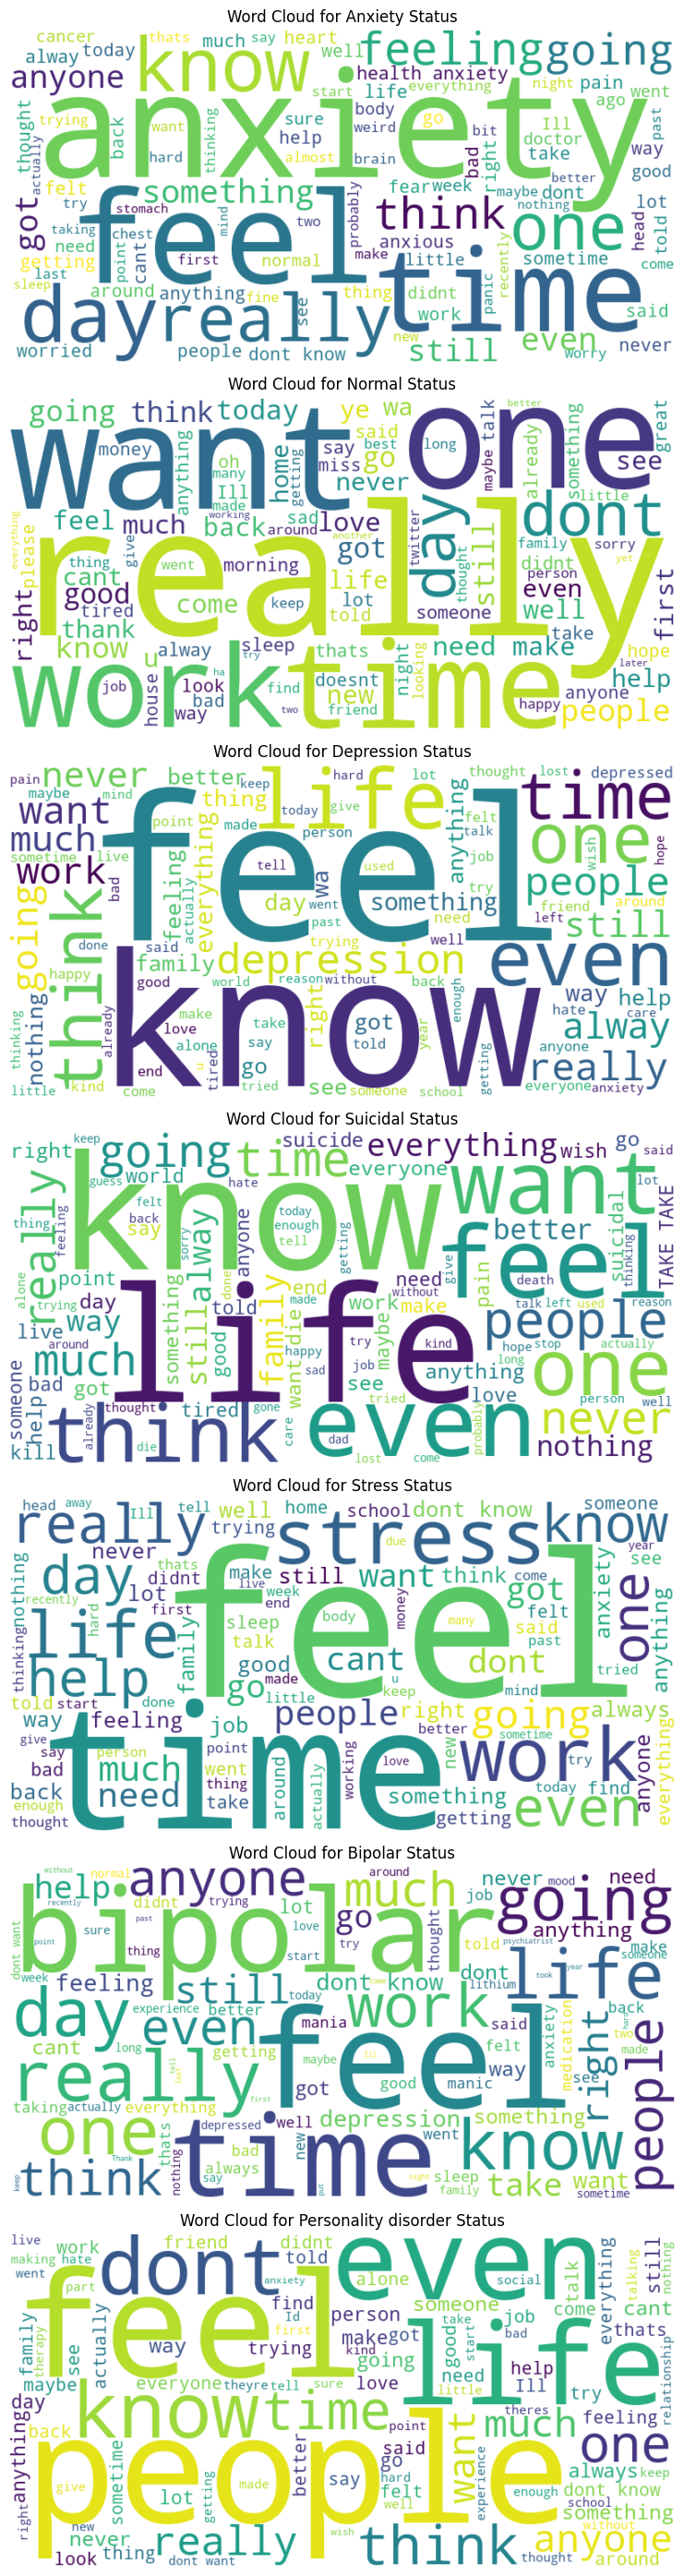

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def create_status_wordclouds(df):
    """
    Generate word clouds for each unique status in the dataframe
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing 'status' and 'statement' columns
    
    Returns:
    --------
    None (displays word clouds)
    """
    # Get unique statuses
    statuses = df['status'].unique()
    
    # Create subplot grid
    fig, axes = plt.subplots(nrows=len(statuses), ncols=1, figsize=(10, 4*len(statuses)))
    
    for i, status in enumerate(statuses):
        # Filter dataframe for current status
        status_df = df[df['status'] == status]
        
        # Combine all statements for this status
        combined_text = ' '.join(status_df['statement'])
        
        # Generate word cloud
        wordcloud = WordCloud(
            width=800, 
            height=400, 
            background_color='white', 
            max_words=100
        ).generate(combined_text)
        
        # Plot word cloud
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].set_title(f'Word Cloud for {status.capitalize()} Status')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Usage example
# Assuming 'df' is your preprocessed DataFrame
create_status_wordclouds(df)

## Deep Learning Model (LSTM) - Attempt 1

**Important Points**
* Use an LSTM model since text data is sequential & context of every word depends on the surrounding words. LSTMs work by maintaining a "hidden state" or memory of previous inputs, which can help the model retain long-term dependencies
* Use a dropout of 20% to introduce regularization to the inputs, which can help avoid overfitting. The model will better generalize to unseen data in validation & testing
* Use a **recurrent dropout** of 20% to regularize the hidden state in the LSTM, which can help the model avoid overfitting as well
* Model Performance
    * Training Accuracy: ~84%
    * Validation/Test Accuracy: ~74%

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
664/664 ━━━━━━━━━━━━━━━━━━━━ 69s 103ms/step - accuracy: 0.3912 - loss: 1.5646 - val_accuracy: 0.5617 - val_loss: 1.2273
Epoch 2/10
664/664 ━━━━━━━━━━━━━━━━━━━━ 72s 108ms/step - accuracy: 0.5541 - loss: 1.2297 - val_accuracy: 0.6067 - val_loss: 0.9839
Epoch 3/10
664/664 ━━━━━━━━━━━━━━━━━━━━ 69s 104ms/step - accuracy: 0.6025 - loss: 0.9661 - val_accuracy: 0.6895 - val_loss: 0.8577
Epoch 4/10
664/664 ━━━━━━━━━━━━━━━━━━━━ 68s 103ms/step - accuracy: 0.7020 - loss: 0.8025 - val_accuracy: 0.7237 - val_loss: 0.7692
Epoch 5/10
664/664 ━━━━━━━━━━━━━━━━━━━━ 68s 102ms/step - accuracy: 0.7426 - loss: 0.7167 - val_accuracy: 0.7313 - val_loss: 0.7431
Epoch 6/10
664/664 ━━━━━━━━━━━━━━━━━━━━ 66s 99ms/step - accuracy: 0.7645 - loss: 0.6513 - val_accuracy: 0.7352 - val_loss: 0.7376
Epoch 7/10
664/664 ━━━━━━━━━━━━━━━━━━━━ 73s 110ms/step - accuracy: 0.7841 - loss: 0.5972 - val_accuracy: 0.7361 - val_loss: 0.7554
Epoch 8/10
664/664 ━━━━━━━━━━━━━━━━━━━━ 71s 107ms/step - accuracy: 0.8008 - loss: 0.

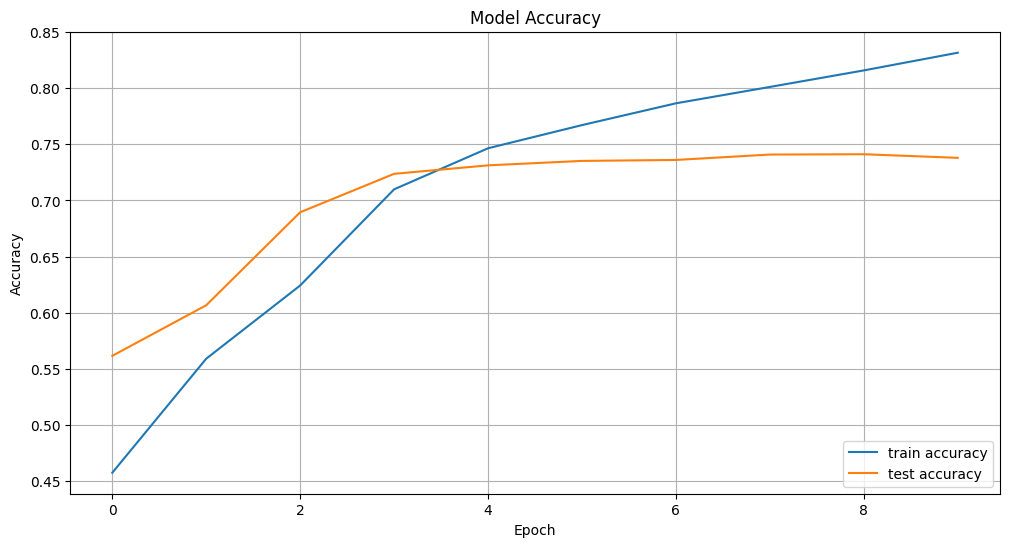

In [10]:
# 2. Build the Deep Learning Model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=maxlen))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 3. Train the Model
history = model.fit(X_train_pad, y_train_cat, epochs=10, batch_size=64, validation_data=(X_test_pad, y_test_cat))

# 4. Plot Accuracy Curve
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## XGBoost

**Important Points**
* Use `TfIdfVectorizer()` to convert the data to a numeric matrix that can be fed as input to the gradient boosting model. Fit to training data and transform both training & testing data
* Use `DMatrix()` since it can handle the TF-IDF sparse matrices more efficiently for XGBoost
* Use `mlogloss` as the loss metric & train for 100 rounds
* Output a confusion matrix for all classes. Darker diagonal cells indicate a greater number of correctly classified samples & darker off-diagonal cells indicate a greater number of misclassified samples
* Graph training & validation/test loss over all training rounds

In [19]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer

X = df['statement']
y = df['status']

vectorizer = TfidfVectorizer(max_features=5000)  # Limit vocabulary to top 5000 words
X_train_tfidf = vectorizer.fit_transform(X_train)  # Fit and transform the training data
X_test_tfidf = vectorizer.transform(X_test)

# Convert your data to DMatrix
dtrain = xgb.DMatrix(X_train_tfidf, label=y_train)
dtest = xgb.DMatrix(X_test_tfidf, label=y_test)

# Set XGBoost parameters
params = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'multi:softprob',
    'num_class': len(np.unique(y)),
    'eval_metric': 'mlogloss'
}

num_round = 100

evals_result = {}

model = xgb.train(
    params, 
    dtrain, 
    num_boost_round=100, 
    evals=[(dtrain, 'train'), (dtest, 'test')], 
    evals_result=evals_result,  # Store evaluation metrics
    early_stopping_rounds=10,   # Stop training if no improvement
    verbose_eval=True
)

# Make predictions
y_pred = model.predict(dtest)
y_pred_classes = np.argmax(y_pred, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Accuracy: {accuracy:.2f}")

[0]	train-mlogloss:1.56258	test-mlogloss:1.56917
[1]	train-mlogloss:1.36819	test-mlogloss:1.37893
[2]	train-mlogloss:1.23947	test-mlogloss:1.25668
[3]	train-mlogloss:1.14640	test-mlogloss:1.16938
[4]	train-mlogloss:1.07578	test-mlogloss:1.10246
[5]	train-mlogloss:1.02018	test-mlogloss:1.05182
[6]	train-mlogloss:0.97548	test-mlogloss:1.01275
[7]	train-mlogloss:0.93953	test-mlogloss:0.98168
[8]	train-mlogloss:0.90984	test-mlogloss:0.95717
[9]	train-mlogloss:0.88383	test-mlogloss:0.93564
[10]	train-mlogloss:0.86151	test-mlogloss:0.91801
[11]	train-mlogloss:0.84251	test-mlogloss:0.90260
[12]	train-mlogloss:0.82481	test-mlogloss:0.88936
[13]	train-mlogloss:0.81011	test-mlogloss:0.87742
[14]	train-mlogloss:0.79701	test-mlogloss:0.86762
[15]	train-mlogloss:0.78496	test-mlogloss:0.85979
[16]	train-mlogloss:0.77339	test-mlogloss:0.85148
[17]	train-mlogloss:0.76341	test-mlogloss:0.84452
[18]	train-mlogloss:0.75308	test-mlogloss:0.83803
[19]	train-mlogloss:0.74356	test-mlogloss:0.83193
[20]	train

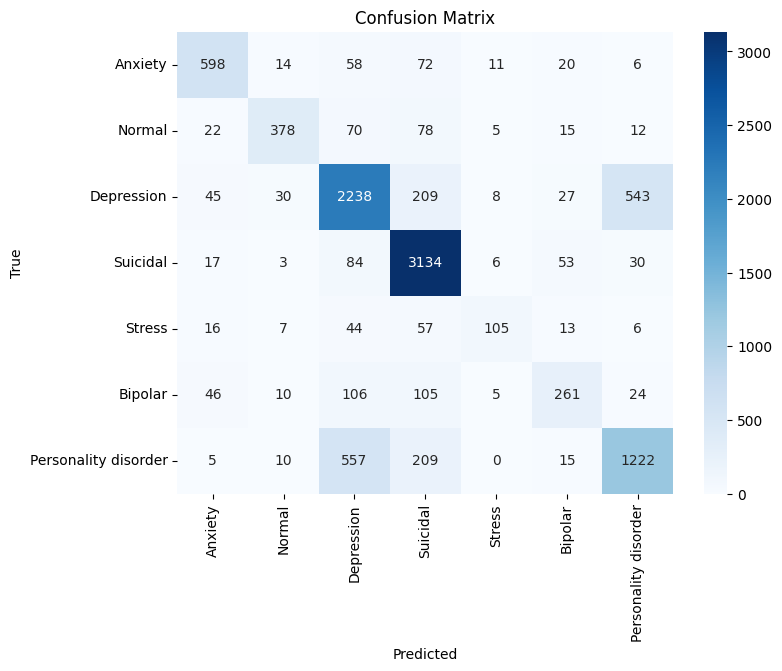

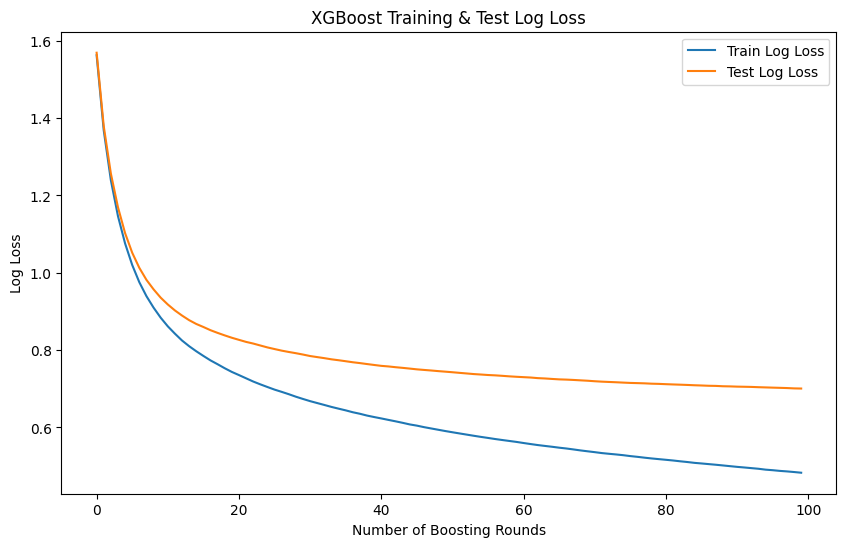

In [20]:
# Plot confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=df['status'].unique(), yticklabels=df['status'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plot the training and test log loss over boosting rounds
plt.figure(figsize=(10, 6))
plt.plot(evals_result['train']['mlogloss'], label='Train Log Loss')
plt.plot(evals_result['test']['mlogloss'], label='Test Log Loss')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Test Log Loss')
plt.legend()
plt.show()


## Naive Bayes, Decision Tree, & Logistic Regression

**Important Points**
* Use TF-IDF encoded matrices for training & testing
* Output a classification report for each model
* Output a confusion matrix for all classes. Darker diagonal cells indicate a greater number of correctly classified samples & darker off-diagonal cells indicate a greater number of misclassified samples
* For the decision tree classifier, output a bar chart of the top 10 most important features used for splitting (use default feature importance calculation)


Results for Bernoulli Naive Bayes:
Accuracy: 0.61

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.55      0.61       779
           1       0.61      0.58      0.59       580
           2       0.69      0.43      0.53      3100
           3       0.65      0.93      0.77      3327
           4       0.48      0.40      0.43       248
           5       0.35      0.49      0.41       557
           6       0.53      0.46      0.49      2018

    accuracy                           0.61     10609
   macro avg       0.57      0.55      0.55     10609
weighted avg       0.62      0.61      0.60     10609



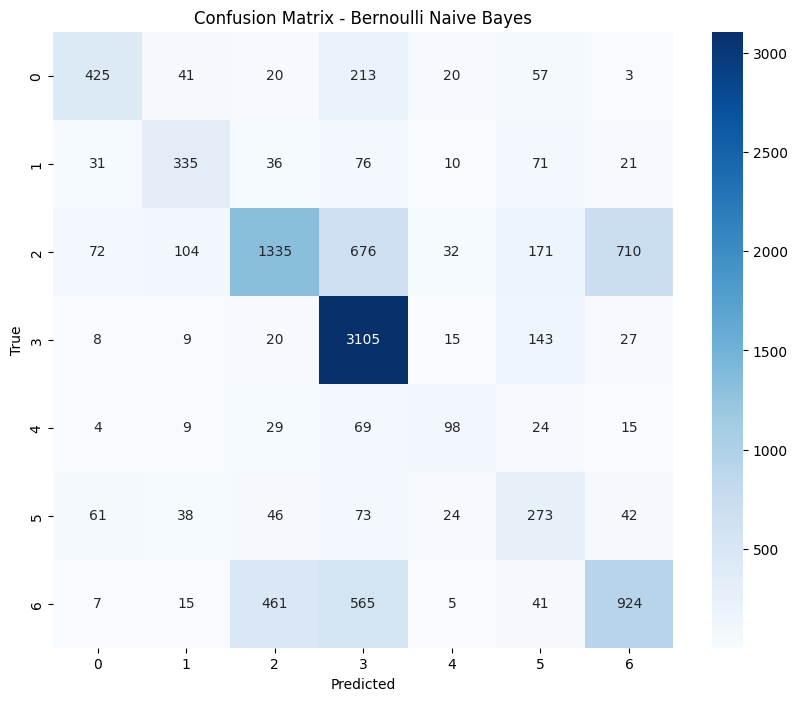


Results for Decision Tree:
Accuracy: 0.62

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.44      0.53       779
           1       0.87      0.35      0.50       580
           2       0.60      0.61      0.60      3100
           3       0.68      0.92      0.78      3327
           4       0.36      0.12      0.19       248
           5       0.39      0.19      0.25       557
           6       0.52      0.48      0.50      2018

    accuracy                           0.62     10609
   macro avg       0.59      0.44      0.48     10609
weighted avg       0.61      0.62      0.60     10609



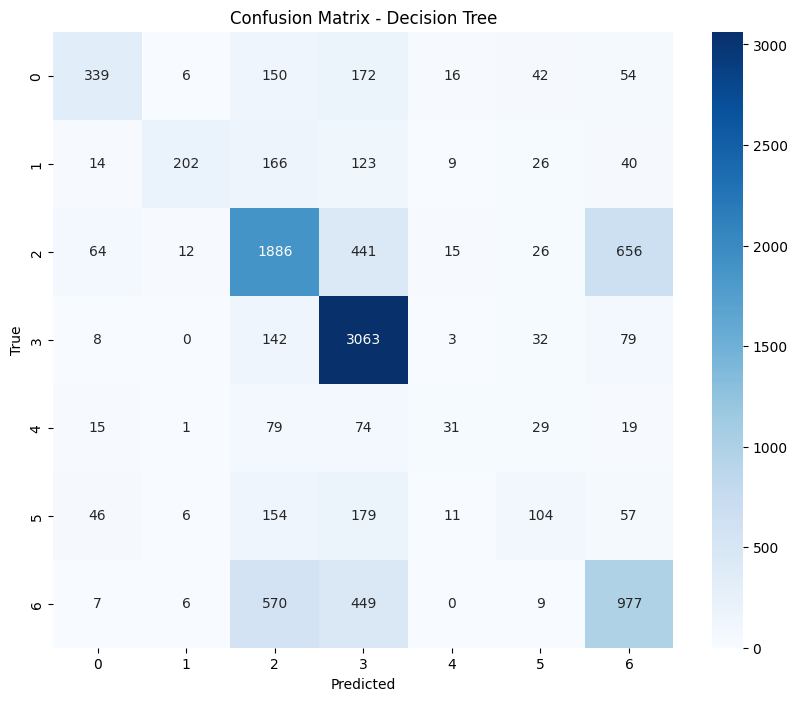

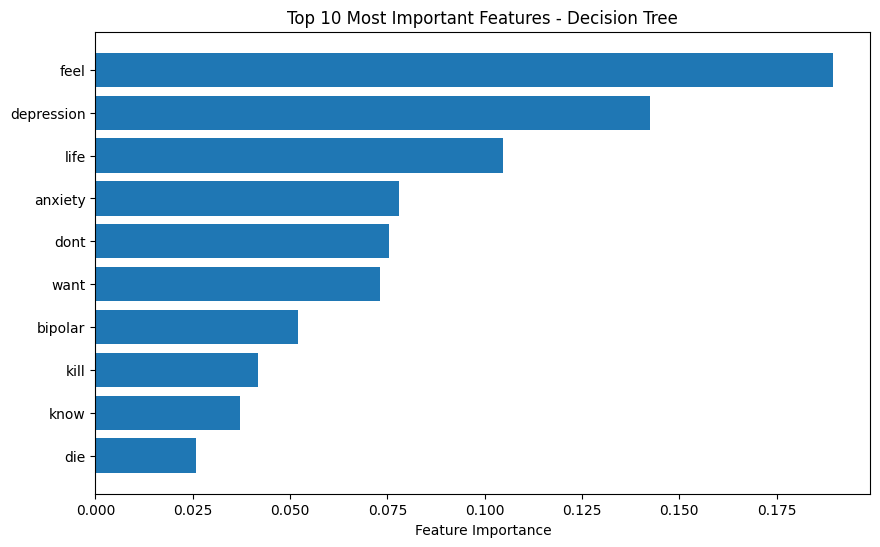


Results for Logistic Regression:
Accuracy: 0.73

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.76      0.77       779
           1       0.77      0.67      0.72       580
           2       0.69      0.68      0.69      3100
           3       0.83      0.92      0.87      3327
           4       0.62      0.44      0.51       248
           5       0.55      0.43      0.48       557
           6       0.62      0.61      0.62      2018

    accuracy                           0.73     10609
   macro avg       0.69      0.64      0.66     10609
weighted avg       0.72      0.73      0.72     10609



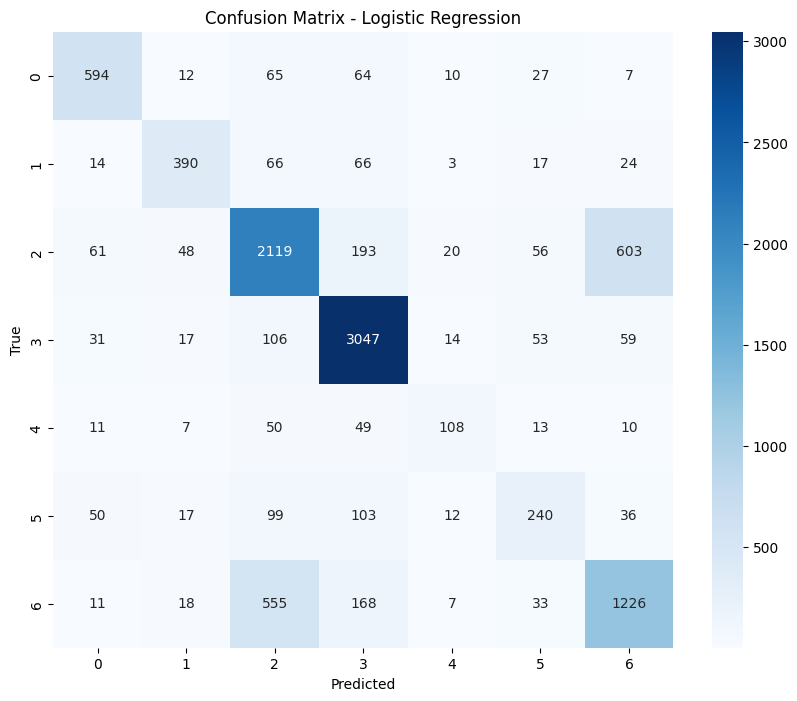

In [ ]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Encode labels if they are categorical
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Define a dictionary of classifiers with their specific parameters
classifiers = {
    'Bernoulli Naive Bayes': BernoulliNB(alpha=0.1, binarize=0.0),
    'Decision Tree': DecisionTreeClassifier(max_depth=9, min_samples_split=5, random_state=101), 
    'Logistic Regression': LogisticRegression(solver='liblinear', penalty='l1', C=10, random_state=101),
}

# Initialize a list to store accuracy scores for each classifier
accuracy_scores = []

# Iterate over each classifier and its name in the classifiers dictionary
for name, clf in classifiers.items():
    # Fit the classifier
    clf.fit(X_train_tfidf, y_train_encoded)
    
    # Make predictions
    y_pred = clf.predict(X_test_tfidf)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test_encoded, y_pred)
    accuracy_scores.append(accuracy)
    
    print(f"\nResults for {name}:")
    print(f"Accuracy: {accuracy:.2f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test_encoded, y_pred, target_names=le.classes_.astype(str)))
    
    # Plot confusion matrix
    conf_mat = confusion_matrix(y_test_encoded, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()
    
    # Plot feature importance (for Decision Tree only)
    if name == 'Decision Tree':
        feature_importance = clf.feature_importances_
        sorted_idx = np.argsort(feature_importance)
        top_10_features = sorted_idx[-10:]

        plt.figure(figsize=(10, 6))
        plt.barh(range(10), feature_importance[top_10_features])
        plt.yticks(range(10), [vectorizer.get_feature_names_out()[i] for i in top_10_features])
        plt.xlabel('Feature Importance')
        plt.title(f'Top 10 Most Important Features - {name}')
        plt.show()


## Deep Learning (LSTM) - Attempt 2

**Important Points**
* Drop empty cell values by converting to `NaN` & dropping null values
* Use same proprocessing, encoding, splitting, & training steps as Attempt 1
* Training & validation/test accuracy **DID NOT** improve
    * Training Accuracy: ~83%
    * Validation/Test Accuracy: ~74%

In [24]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import nltk

# # Download NLTK resources
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('words')

# Load the data
df = pd.read_csv('Combined Data.csv', index_col=0)
df.head()

# remove empty values
df.replace('', np.nan, inplace=True)
df.dropna(inplace=True)

# Preprocess the text data
stop_words = set(stopwords.words('english'))
english_words = set(nltk.corpus.words.words())

def preprocess_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize and remove stopwords and non-English words
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words and word.lower() in english_words]
    return ' '.join(filtered_tokens)

df['statement'] = df['statement'].apply(preprocess_text)

# Encode status labels
label_encoder = LabelEncoder()
df['status_encoded'] = label_encoder.fit_transform(df['status'])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['statement'], df['status_encoded'], test_size=0.2, random_state=42)

# Tokenize the text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform input size
maxlen = 100
X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=maxlen)

# Convert target variables to categorical
num_classes = len(label_encoder.classes_)
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

X_train_pad

array([[   4,    1,  233, ...,    0,    0,    0],
       [  39,  127,  769, ...,    0,    0,    0],
       [  55,  581, 1099, ...,  320,   32,   17],
       ...,
       [  39,    8,   14, ...,    0,    0,    0],
       [ 774,  306,    0, ...,    0,    0,    0],
       [  61,   73, 1533, ...,    0,    0,    0]], dtype=int32)

In [25]:
print(df.head())

print("Length:", len(df),"\n")
status_percentages = df['status'].value_counts(normalize=True) * 100

print("Percentage of data by status:")
for status, percentage in status_percentages.items():
    print(f"{status}: {percentage:.2f}%")

                                           statement   status  status_encoded
0                                            oh gosh  Anxiety               0
1  trouble sleeping confused mind restless heart ...  Anxiety               0
2  wrong back dear forward doubt Stay restless re...  Anxiety               0
3                 focus something else still worried  Anxiety               0
4                   restless restless month boy mean  Anxiety               0
Length: 52681 

Percentage of data by status:
Normal: 31.02%
Depression: 29.24%
Suicidal: 20.22%
Anxiety: 7.29%
Bipolar: 5.27%
Stress: 4.91%
Personality disorder: 2.04%


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 73s 109ms/step - accuracy: 0.3829 - loss: 1.5731 - val_accuracy: 0.5307 - val_loss: 1.2954
Epoch 2/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 72s 108ms/step - accuracy: 0.5396 - loss: 1.2936 - val_accuracy: 0.5537 - val_loss: 1.1299
Epoch 3/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 67s 102ms/step - accuracy: 0.5912 - loss: 1.0522 - val_accuracy: 0.6635 - val_loss: 0.8611
Epoch 4/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 64s 97ms/step - accuracy: 0.6775 - loss: 0.8355 - val_accuracy: 0.6958 - val_loss: 0.8111
Epoch 5/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 66s 100ms/step - accuracy: 0.7248 - loss: 0.7443 - val_accuracy: 0.7113 - val_loss: 0.7797
Epoch 6/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 63s 95ms/step - accuracy: 0.7481 - loss: 0.6870 - val_accuracy: 0.7314 - val_loss: 0.7403
Epoch 7/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 65s 99ms/step - accuracy: 0.7779 - loss: 0.6167 - val_accuracy: 0.7366 - val_loss: 0.7116
Epoch 8/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 65s 98ms/step - accuracy: 0.7929 - loss: 0.575

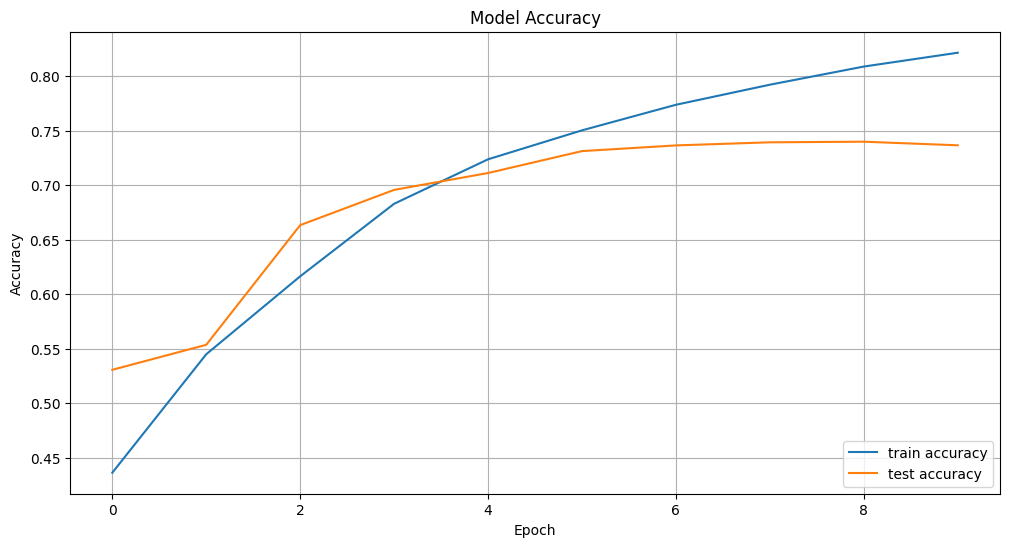

In [26]:
# 2. Build the Deep Learning Model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=maxlen))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 3. Train the Model
history = model.fit(X_train_pad, y_train_cat, epochs=10, batch_size=64, validation_data=(X_test_pad, y_test_cat))

# 4. Plot Accuracy Curve
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Deep Learning Model (LSTM) - Attempt 3

**Important Points**
* Drop empty cell values by converting to `NaN` & dropping null values
* Use same proprocessing, encoding, splitting, & training steps as Attempts 1 & 2
* Remove `personality disorder` & `bipolar` categories from target variable (`status`). If you review the text in those categories, it is full of people talking about their experience with these disorders, which is not indicative of their current mood.
    * Additionally, it is hard to track those disorders without comparing non-BPD tweets with their BPD-indicative tweets. With the deep learning model, we are trying to predict a person's mental health status on a scale of normal to suicidal
* Oversample data so that the dataset would be balanced equally across the 5 remaining statuses (20% each)
* Both training & validation accuracy improved significantly
    * Training Accuracy: ~95%
    * Validation/Test Accuracy: ~90%

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.src.legacy.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.utils import to_categorical

# 1. Load Data
df = pd.read_csv('Combined Data.csv')
print(df.head())

print("Length:", len(df),"\n")

status_percentages = df['status'].value_counts(normalize=True) * 100
print("Percentage of data by status:")
for status, percentage in status_percentages.items():
    print(f"{status}: {percentage:.2f}%")

   Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety
Length: 53043 

Percentage of data by status:
Normal: 30.83%
Depression: 29.04%
Suicidal: 20.08%
Anxiety: 7.33%
Bipolar: 5.42%
Stress: 5.03%
Personality disorder: 2.26%


In [39]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import nltk

# Download NLTK resources (uncomment if not already downloaded)
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('words')

# Remove empty values
df.replace('', np.nan, inplace=True)
df.dropna(inplace=True)

# Preprocess the text data
stop_words = set(stopwords.words('english'))
english_words = set(nltk.corpus.words.words())

def preprocess_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize and remove stopwords and non-English words
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words and word.lower() in english_words]
    return ' '.join(filtered_tokens)

df['statement'] = df['statement'].apply(preprocess_text)

# Remove rows with 'bipolar' or 'personality disorder' in the status column
df = df[~df['status'].str.contains('bipolar|personality disorder', case=False, na=False)]

# Oversampling to balance classes
df_normal = df[df['status'] == 'Normal']
df_depression = df[df['status'] == 'Depression']
df_suicidal = df[df['status'] == 'Suicidal']
df_anxiety = df[df['status'] == 'Anxiety']
df_stress = df[df['status'] == 'Stress']

# Find the maximum size among all categories
max_size = max(len(df_normal), len(df_depression), len(df_suicidal), len(df_anxiety), len(df_stress))

# Perform oversampling on each category to match the maximum size
df_normal_oversampled = resample(df_normal, 
                                  replace=True,     # sample with replacement
                                  n_samples=max_size,    # to match majority class
                                  random_state=42) # reproducible results

df_depression_oversampled = resample(df_depression, 
                                      replace=True,
                                      n_samples=max_size,
                                      random_state=42)

df_suicidal_oversampled = resample(df_suicidal, 
                                    replace=True,
                                    n_samples=max_size,
                                    random_state=42)

df_anxiety_oversampled = resample(df_anxiety, 
                                   replace=True,
                                   n_samples=max_size,
                                   random_state=42)

df_stress_oversampled = resample(df_stress, 
                                  replace=True,
                                  n_samples=max_size,
                                  random_state=42)

# Combine all oversampled dataframes into one
df_balanced = pd.concat([df_normal_oversampled, 
                          df_depression_oversampled, 
                          df_suicidal_oversampled, 
                          df_anxiety_oversampled, 
                          df_stress_oversampled])

# Shuffle the dataframe to mix up the classes
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Encode status labels
label_encoder = LabelEncoder()
df_balanced['status_encoded'] = label_encoder.fit_transform(df_balanced['status'])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_balanced['statement'], 
                                                    df_balanced['status_encoded'], 
                                                    test_size=0.2, 
                                                    random_state=42)

X_train.head()

38752    keep place notable left elbow skinny dude pain...
30263    fun thing writing sometimes story pull questio...
50466                                      thats good idea
4348     really regret chance finally end stop thinking...
43045    Distraction suffer extreme health anxiety main...
Name: statement, dtype: object

In [40]:
print(df_balanced.head())

print("Length:", len(df_balanced),"\n")

status_percentages = df_balanced['status'].value_counts(normalize=True) * 100
print("Percentage of data by status:")
for status, percentage in status_percentages.items():
    print(f"{status}: {percentage:.2f}%")

   Unnamed: 0                                          statement      status  \
0       48788  physics class go helpless feel course hate pro...      Stress   
1       20371  guess optional text community quite optional T...  Depression   
2       12404  Hey feel like everything everyone Went univers...  Depression   
3       52198  major anxiety attack right cause starting new ...     Anxiety   
4       51936  Possible trigger warning anxiety tongue bad an...     Anxiety   

   status_encoded  
0               3  
1               1  
2               1  
3               0  
4               0  
Length: 77620 

Percentage of data by status:
Stress: 20.00%
Depression: 20.00%
Anxiety: 20.00%
Normal: 20.00%
Suicidal: 20.00%


In [41]:
# Tokenize the text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform input size
maxlen = 100
X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=maxlen)

# Convert target variables to categorical
num_classes = len(label_encoder.classes_)
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

X_train_pad

array([[  72,  170, 4642, ...,    0,    0,    0],
       [ 329,   55,  399, ...,    0,    0,    0],
       [ 218,   38,  260, ...,    0,    0,    0],
       ...,
       [ 158,    4,  334, ...,    0,    0,    0],
       [  29,  198,    0, ...,    0,    0,    0],
       [ 436,   48,  647, ...,    0,    0,    0]], dtype=int32)

Epoch 1/10
971/971 ━━━━━━━━━━━━━━━━━━━━ 94s 95ms/step - accuracy: 0.3079 - loss: 1.4881 - val_accuracy: 0.6058 - val_loss: 0.9554
Epoch 2/10
971/971 ━━━━━━━━━━━━━━━━━━━━ 91s 94ms/step - accuracy: 0.7088 - loss: 0.7411 - val_accuracy: 0.8102 - val_loss: 0.5129
Epoch 3/10
971/971 ━━━━━━━━━━━━━━━━━━━━ 93s 96ms/step - accuracy: 0.8245 - loss: 0.4732 - val_accuracy: 0.8361 - val_loss: 0.4466
Epoch 4/10
971/971 ━━━━━━━━━━━━━━━━━━━━ 91s 93ms/step - accuracy: 0.8627 - loss: 0.3786 - val_accuracy: 0.8638 - val_loss: 0.4032
Epoch 5/10
971/971 ━━━━━━━━━━━━━━━━━━━━ 89s 91ms/step - accuracy: 0.8905 - loss: 0.3104 - val_accuracy: 0.8735 - val_loss: 0.3816
Epoch 6/10
971/971 ━━━━━━━━━━━━━━━━━━━━ 88s 91ms/step - accuracy: 0.9095 - loss: 0.2664 - val_accuracy: 0.8840 - val_loss: 0.3583
Epoch 7/10
971/971 ━━━━━━━━━━━━━━━━━━━━ 88s 91ms/step - accuracy: 0.9216 - loss: 0.2317 - val_accuracy: 0.8902 - val_loss: 0.3544
Epoch 8/10
971/971 ━━━━━━━━━━━━━━━━━━━━ 87s 89ms/step - accuracy: 0.9333 - loss: 0.2026 - 

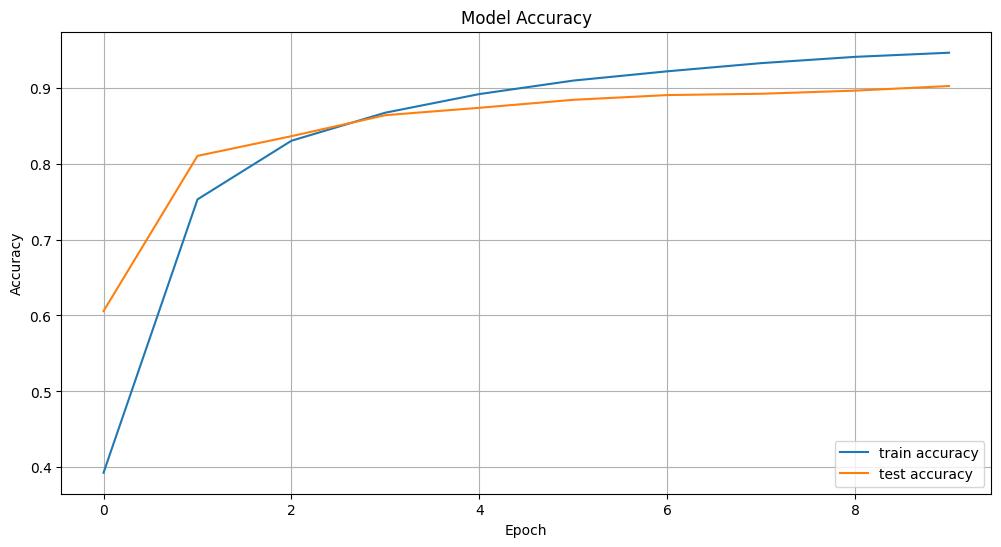

In [43]:
# 2. Build the Deep Learning Model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 3. Train the Model
history = model.fit(X_train_pad, y_train_cat, epochs=10, batch_size=64, validation_data=(X_test_pad, y_test_cat))

# 4. Plot Accuracy Curve
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [44]:
from sklearn.metrics import classification_report
import numpy as np

# Make predictions on the test set
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded test labels back to class labels
y_test_classes = np.argmax(y_test_cat, axis=1)

# Generate the classification report
report = classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_)

print("Classification Report:")
print(report)

486/486 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step
Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.96      0.98      0.97      3100
  Depression       0.84      0.76      0.80      3016
      Normal       0.94      0.92      0.93      3132
      Stress       0.95      0.99      0.97      3107
    Suicidal       0.81      0.86      0.84      3169

    accuracy                           0.90     15524
   macro avg       0.90      0.90      0.90     15524
weighted avg       0.90      0.90      0.90     15524



## Deep Learning Model with VADER Sentiment Analysis (LSTM) - Attempt 4

**Important Points**
* Drop empty cell values by converting to `NaN` & dropping null values
* Use same proprocessing, encoding, splitting, & training steps as Attempts 1-3
* Remove `personality disorder` & `bipolar` categories from target variable (`status`)
* The models all have some trouble correctly identifying stress. They also seem to confuse depression with suicide (high FP rates for both categories in the confusion matrices)
* Oversample data so that the dataset would be balanced equally across the 5 remaining statuses (20% each)
* Both training & validation/test accuracy remained the same as Attempt 3
    * Training Accuracy: ~95%
    * Validation/Test Accuracy: ~90%

**VADER Sentiment Analysis**
* Add a feature to determine how negative the text is using VADER sentiment analysis (ex. suicidal person will have a more negative message than a depressed person)
* Can help the model associate certain statements with certain moods, which might help improve classification accuracy

In [47]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import nltk

df = pd.read_csv("Combined Data.csv")

# Download NLTK resources (uncomment if not already downloaded)
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('words')

# Remove empty values
df.replace('', np.nan, inplace=True)
df.dropna(inplace=True)

# Preprocess the text data
stop_words = set(stopwords.words('english'))
english_words = set(nltk.corpus.words.words())

def preprocess_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize and remove stopwords and non-English words
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words and word.lower() in english_words]
    return ' '.join(filtered_tokens)

df['statement'] = df['statement'].apply(preprocess_text)

# Encode status labels
label_encoder = LabelEncoder()
df['status_encoded'] = label_encoder.fit_transform(df['status'])

# Remove rows with 'bipolar' or 'personality disorder' in the status column
df = df[~df['status'].str.contains('bipolar|personality disorder', case=False, na=False)]

# Oversampling to balance classes
df_normal = df[df['status'] == 'Normal']
df_depression = df[df['status'] == 'Depression']
df_suicidal = df[df['status'] == 'Suicidal']
df_anxiety = df[df['status'] == 'Anxiety']
df_stress = df[df['status'] == 'Stress']

# Find the maximum size among all categories
max_size = max(len(df_normal), len(df_depression), len(df_suicidal), len(df_anxiety), len(df_stress))

# Perform oversampling on each category to match the maximum size
df_normal_oversampled = resample(df_normal, 
                                  replace=True,     # sample with replacement
                                  n_samples=max_size,    # to match majority class
                                  random_state=42) # reproducible results

df_depression_oversampled = resample(df_depression, 
                                      replace=True,
                                      n_samples=max_size,
                                      random_state=42)

df_suicidal_oversampled = resample(df_suicidal, 
                                    replace=True,
                                    n_samples=max_size,
                                    random_state=42)

df_anxiety_oversampled = resample(df_anxiety, 
                                   replace=True,
                                   n_samples=max_size,
                                   random_state=42)

df_stress_oversampled = resample(df_stress, 
                                  replace=True,
                                  n_samples=max_size,
                                  random_state=42)

# Combine all oversampled dataframes into one
df_balanced = pd.concat([df_normal_oversampled, 
                          df_depression_oversampled, 
                          df_suicidal_oversampled, 
                          df_anxiety_oversampled, 
                          df_stress_oversampled])

# Shuffle the dataframe to mix up the classes
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_balanced['statement'], 
                                                    df_balanced['status_encoded'], 
                                                    test_size=0.2, 
                                                    random_state=42)

X_train.head()

44192    away suicide autistic noise sensitive mum hous...
23325    Distrust diagnoses overcome quite severe healt...
24342    twice read like definitely lot enough share ev...
27271                          bring glove catch foul ball
10831    Stress health back end went dermatologist biop...
Name: statement, dtype: object

In [48]:
print(df_balanced.head())

print("Length:", len(df),"\n")

status_percentages = df_balanced['status'].value_counts(normalize=True) * 100
print("Percentage of data by status:")
for status, percentage in status_percentages.items():
    print(f"{status}: {percentage:.2f}%")

   Unnamed: 0                                          statement      status  \
0       32880                                               many      Normal   
1       21605  life people like feel like put take even know ...    Suicidal   
2       13533  ago car accident instead older sister meanwhil...    Suicidal   
3       31067                                                         Normal   
4       22217  since waking early supposed help depressive go...  Depression   

   status_encoded  
0               3  
1               6  
2               6  
3               3  
4               2  
Length: 48827 

Percentage of data by status:
Normal: 20.00%
Suicidal: 20.00%
Depression: 20.00%
Anxiety: 20.00%
Stress: 20.00%


In [50]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Assuming df_balanced has columns 'text' for the input text and 'label' for the target labels

# 1. Preprocess the data
texts = df_balanced['statement'].values  # Extract text data
labels = df_balanced['status'].values  # Extract labels

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)
num_classes = len(np.unique(y_encoded))
y_train_cat = np.eye(num_classes)[y_encoded]  # One-hot encoding

# Tokenization and Padding (example parameters)
max_length = 100  # Maximum length of padded sequences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(texts)
X_train_seq = tokenizer.texts_to_sequences(texts)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)

# 2. Perform VADER sentiment analysis
sia = SentimentIntensityAnalyzer()

def get_vader_scores(text):
    return sia.polarity_scores(text)

vader_scores = [get_vader_scores(text) for text in texts]

# Extract VADER features
vader_features = np.array([[score['neg'], score['neu'], score['pos'], score['compound']] for score in vader_scores])

# Combine VADER features with existing features
X_combined = np.concatenate((X_train_pad, vader_features), axis=1)

# Split into training and testing sets (adjust according to your dataset)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_encoded, test_size=0.2, random_state=42)

# One-hot encode labels for training and testing sets
y_train_cat = np.eye(num_classes)[y_train]
y_test_cat = np.eye(num_classes)[y_test]

X_train

array([[ 0.000e+00,  0.000e+00,  0.000e+00, ...,  5.170e-01,  9.500e-02,
        -8.316e-01],
       [ 9.860e+02,  3.530e+02,  3.750e+02, ...,  4.810e-01,  1.440e-01,
        -9.884e-01],
       [ 0.000e+00,  0.000e+00,  0.000e+00, ...,  3.500e-01,  5.180e-01,
         7.873e-01],
       ...,
       [ 0.000e+00,  0.000e+00,  0.000e+00, ...,  4.820e-01,  2.650e-01,
         2.580e-02],
       [ 7.400e+01,  7.200e+01,  4.093e+03, ...,  3.740e-01,  3.040e-01,
        -7.713e-01],
       [ 0.000e+00,  0.000e+00,  0.000e+00, ...,  1.000e+00,  0.000e+00,
         0.000e+00]])

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1022/1022 ━━━━━━━━━━━━━━━━━━━━ 102s 97ms/step - accuracy: 0.5073 - loss: 1.1294 - val_accuracy: 0.7616 - val_loss: 0.6207
Epoch 2/10
1022/1022 ━━━━━━━━━━━━━━━━━━━━ 99s 97ms/step - accuracy: 0.7797 - loss: 0.5915 - val_accuracy: 0.8237 - val_loss: 0.4892
Epoch 3/10
1022/1022 ━━━━━━━━━━━━━━━━━━━━ 97s 94ms/step - accuracy: 0.8373 - loss: 0.4539 - val_accuracy: 0.8423 - val_loss: 0.4306
Epoch 4/10
1022/1022 ━━━━━━━━━━━━━━━━━━━━ 100s 98ms/step - accuracy: 0.8653 - loss: 0.3788 - val_accuracy: 0.8614 - val_loss: 0.3983
Epoch 5/10
1022/1022 ━━━━━━━━━━━━━━━━━━━━ 98s 96ms/step - accuracy: 0.8873 - loss: 0.3219 - val_accuracy: 0.8703 - val_loss: 0.3678
Epoch 6/10
1022/1022 ━━━━━━━━━━━━━━━━━━━━ 95s 93ms/step - accuracy: 0.9006 - loss: 0.2840 - val_accuracy: 0.8782 - val_loss: 0.3572
Epoch 7/10
1022/1022 ━━━━━━━━━━━━━━━━━━━━ 93s 90ms/step - accuracy: 0.9129 - loss: 0.2488 - val_accuracy: 0.8867 - val_loss: 0.3376
Epoch 8/10
1022/1022 ━━━━━━━━━━━━━━━━━━━━ 94s 92ms/step - accuracy: 0.9250 - loss: 0.

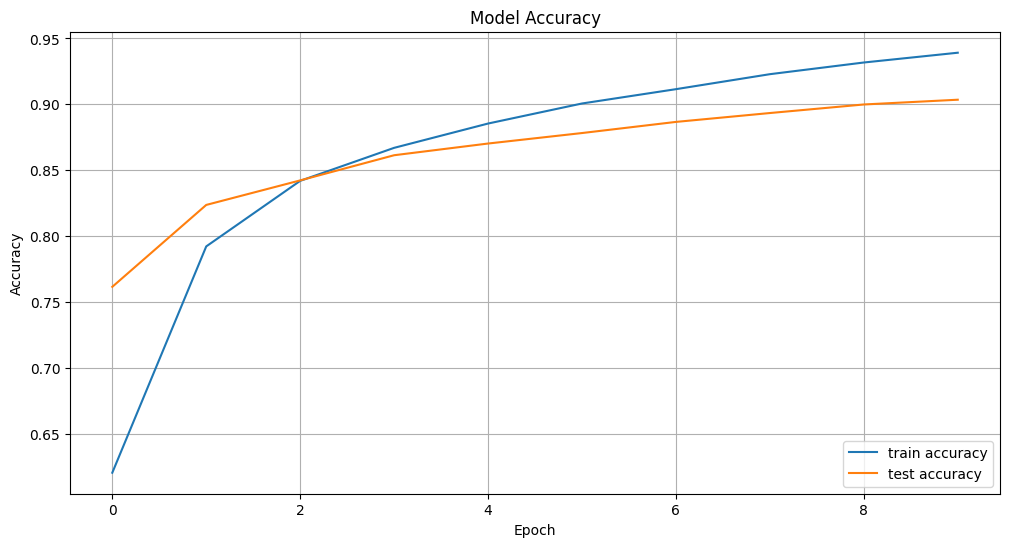

In [51]:
# 3. Build the Deep Learning Model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_length))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.3))

# Add a layer for VADER features (4 features: neg, neu, pos, compound)
model.add(Dense(units=16, activation='relu', input_shape=(4,)))

# Concatenate LSTM output with VADER features
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 4. Train the Model
history = model.fit(
    X_train,
    y_train_cat,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test_cat)
)

# 5. Plot Accuracy Curve
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

511/511 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step
Accuracy: 90.35%
              precision    recall  f1-score   support

     Anxiety       0.95      0.98      0.97      3291
  Depression       0.87      0.75      0.80      3227
      Normal       0.93      0.92      0.93      3246
      Stress       0.97      0.98      0.97      3312
    Suicidal       0.80      0.88      0.84      3267

    accuracy                           0.90     16343
   macro avg       0.90      0.90      0.90     16343
weighted avg       0.90      0.90      0.90     16343



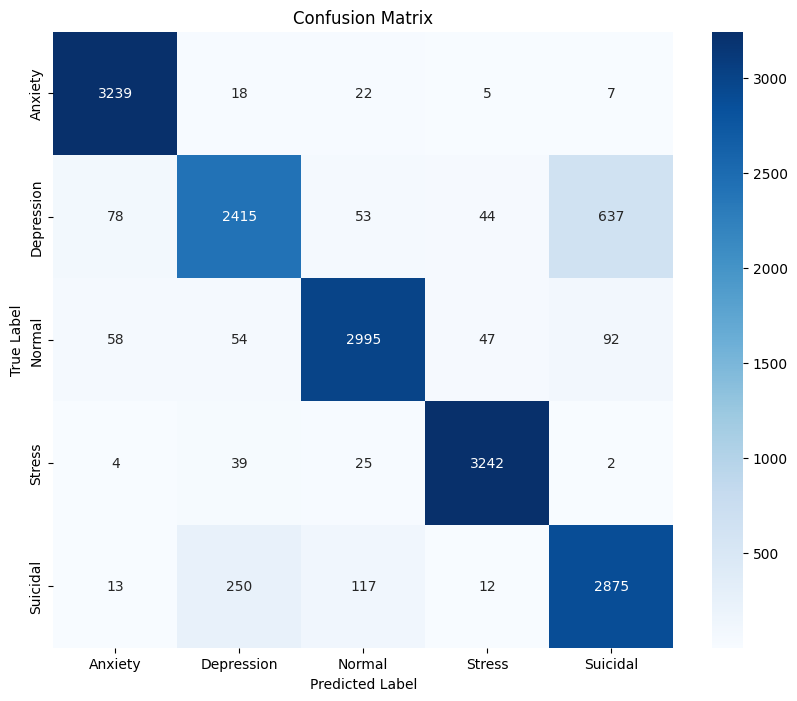

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Assuming you have already trained your model and have X_test and y_test

# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Get class names (assuming you have them stored or can retrieve them)
class_names = label_encoder.classes_

# Print classification report and accuracy
print(f"Accuracy: {accuracy_score(y_true, y_pred_classes)*100:.2f}%")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Conclusion

We chose LSTM as our primary model since these RNNs have a "hidden state" that helps them remember long-term dependencies through the use of gates to remember/forget information. Text data tends to be sequential since the context & meaning of words depends on the surrounding words, leading us to believe the LSTM model as the best fit. The LSTM model generally performs better than the Naive Bayes, Decision Tree, Logistic Regression, and Gradient Boosting models. This is in part due to the different regularization techniques used such as dropout & recurrent dropout for the hidden state. It is also dependent upon the batch size used since smaller batch sizes can lead to better convergence for deep learning models. However, dropping the "bipolar" and "personality disorder" categories from the target variable in the dataset led to a significant jump in model performance, both in training & validation/testing accuracy. This is most likely due to the text between both categories being similar, leading to confusion for the model during predictions regarding which is the correct classification. This resulted in a training accuracy jump from ~84% to ~95% and a validation/test accuracy jump from ~74% to ~90%. After adding VADER sentiment scores as a feature to the dataset in Attempt 4, the accuracy stayed around the same.

The main limitation of this model is that if it encounters out-of-sample text that corresponds to the either of the status labels that were dropped, it will misclassify the statements. Future improvements can be done via feature engineering to increase accuracy without dropping any labels to avoid compromising prediction accuracy in production environments.